### This is for Cohort 0 data

In [73]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import harp
import plotly.express as px

from harp_resources import process, utils
from sleap import load_and_process as lp

# Define paths
data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort2_like_test_data/2025-01-13T15-47-26')
photometry_path = data_path.parent / f"{data_path.name}_processedData" / "photometry"

# Load photometry data
print("Loading processed fluorescence")
photometry_data = pd.read_csv(photometry_path / "Processed_fluorescence.csv")

print("Loading processed fluorescence info")
photometry_info = pd.read_csv(photometry_path / "Info.csv")

print("Loading processed fluorescence events")
photometry_events = pd.read_csv(photometry_path / "Events.csv")

# Extract event timestamps
photometry_sync_events = photometry_events.dropna(subset=["Name"])  # Keep only rows with events

# Ensure "Name" column is string type and process event values safely
def extract_event_value(event_name):
    """Extracts a numeric value from event names, if formatted as 'X*Y*Z'."""
    parts = str(event_name).split('*')
    return int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else None

photometry_sync_events["Extracted_Value"] = photometry_sync_events["Name"].apply(extract_event_value)
photometry_sync_events.dropna(subset=["Extracted_Value"], inplace=True)

# Plot fluorescence data
plt.figure()
plt.plot(photometry_data["dfF_410"], label="CH1-410")
plt.plot(photometry_data["dfF_470"], label="CH1-470")
plt.plot(photometry_data["dfF_560"], label="CH1-560")
plt.legend()
plt.show()

# # Interactive Plotly plot
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=photometry_data["TimeStamp"], y=photometry_data["dfF_410"], mode='lines', name="CH1-410"))
# fig.add_trace(go.Scatter(x=photometry_data["TimeStamp"], y=photometry_data["dfF_470"], mode='lines', name="CH1-470"))
# fig.add_trace(go.Scatter(x=photometry_data["TimeStamp"], y=photometry_data["dfF_560"], mode='lines', name="CH1-560"))
# fig.update_layout(title="Photometry Fluorescence Data", xaxis_title="Time (s)", yaxis_title="Fluorescence (df/F)")
# fig.show()


ModuleNotFoundError: No module named 'harp_resources'

In [70]:
import harp
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import cv2
import numpy as np
import utils
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers
from aeon.io.reader import Reader, Csv
from dotmap import DotMap
import aeon.io.api as api
import os
from pathlib import Path


root_folder = r'/Users/rancze/Documents/Data/vestVR/Cohort2_like_test_data/2025-01-13T15-47-26'
root_folder_photometry = root_folder / f"{root_folder.name}_processedData" / "photometry"

#data_folder = '/Users/rancze/Documents/Data/vestVR/Cohort2_like_test_data/2025-01-13T15-47-26'
#photometry_path = data_path.parent / f"{data_path.name}_processedData" / "photometry"

h1_reader = harp.create_reader('h1-device.yml', epoch=harp.REFERENCE_EPOCH)
h2_reader = harp.create_reader('h2-device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData("SessionSettings")
experiment_events_reader = utils.TimestampedCsvReader("ExperimentEvents", columns=["Event"])
framecount_reader = utils.TimestampedCsvReader("OnixAnalogFrameCount", columns=["Index"])
photometry_reader = utils.PhotometryReader("Processed_fluorescence")
video_reader = utils.Video("VideoData1")
onix_digital_reader = utils.TimestampedCsvReader("OnixDigital", columns=["Clock", "HubClock", "DigitalInputs", "Buttons"])
onix_harp_reader = utils.TimestampedCsvReader("OnixHarp", columns=["Clock", "HubClock", "HarpTime"])

h1_datafolder = r'/Users/rancze/Documents/Data/vestVR/Cohort2_like_test_data/2025-01-13T15-47-26//HarpDataH1/'
h2_datafolder = r'/Users/rancze/Documents/Data/vestVR/Cohort2_like_test_data/2025-01-13T15-47-26//HarpDataH2/'

In [41]:
# read experiment metadata
session_settings = utils.load(session_data_reader, root_folder)

print(session_settings.iloc[0]['metadata'].blocks[1].haltProtocol)

DotMap(randomDelay=1.5, minumumDelay=0.1, haltGain=1.0, haltMotorGain=1.0, haltTime=2.0)


In [42]:
# read harp streams, experiment events, video
flow_sensor = utils.load_harp(h1_reader.OpticalTrackingRead, h1_datafolder)
camera_triggers = utils.load_harp(h1_reader.Cam0Event, h1_datafolder)
# immediate_pulses = utils.load_harp(h2_reader.ImmediatePulses, h2_datafolder)
analog_input = utils.load_harp(h2_reader.AnalogInput, h2_datafolder)
experiment_events = utils.load(experiment_events_reader, root_folder)
# video_data = utils.load(video_reader, root_folder)

                                          Event       Seconds
Time                                                         
1904-01-05 01:45:41.430240  Sync signal started  351941.43024


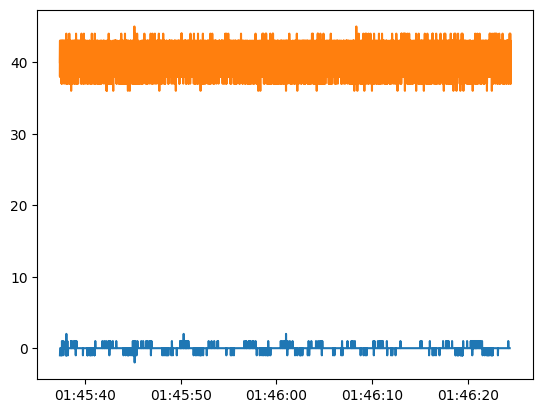

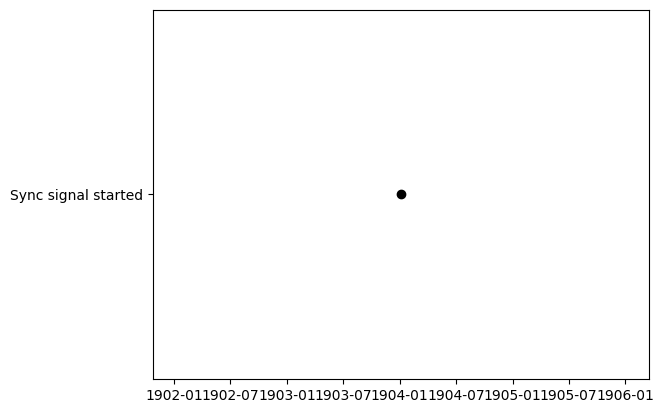

In [43]:
print(experiment_events)

plt.figure()
plt.plot(flow_sensor['OpticalTrackingRead0Y'])
plt.plot(analog_input['AnalogInput'])

plt.figure()
plt.scatter(experiment_events.index, experiment_events["Event"], c='k')

In [44]:
# read onix streams
# stream assigns a harp timestamp to each analog block
analog_frame_count = utils.load(framecount_reader, root_folder)

# load onix digital data
digital_data = utils.load(onix_digital_reader, root_folder)

# load harp timestamps
onix_harp = utils.load(onix_harp_reader, root_folder)
onix_harp["HarpTime"] = onix_harp["HarpTime"] + 1 # known issue with current version of ONIX, harp timestamps lag 1 second

# directly read an onix analog data / clock bin file
analog_data = utils.read_onix_analog_data(root_folder, "OnixAnalogData", np.int16)
analog_clock = utils.read_onix_analog_clock(root_folder, "OnixAnalogClock", np.uint64)

# confirm relationship between data, clock and frame count
print(analog_data.shape[0], analog_clock.shape[0], analog_frame_count["Index"][-1])

4699000 4699000 47004


/var/folders/n7/dvksxsf55hxbzrrfm5gv88cwmxqfb7/T/ipykernel_47309/1770119561.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(analog_data.shape[0], analog_clock.shape[0], analog_frame_count["Index"][-1])


/var/folders/n7/dvksxsf55hxbzrrfm5gv88cwmxqfb7/T/ipykernel_47309/1609032919.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(clock[window], harp[window], c='k', s=2)
/var/folders/n7/dvksxsf55hxbzrrfm5gv88cwmxqfb7/T/ipykernel_47309/1609032919.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(clock[window], onix_to_harp_seconds(clock[window]), c='r')


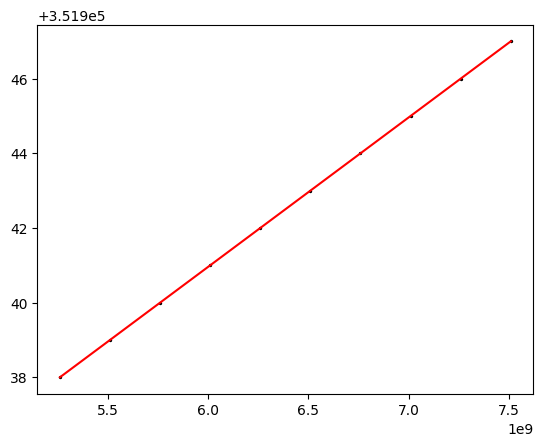

In [45]:
# define conversion functions between timestamps (onix to harp)
clock = onix_harp["Clock"] # ONIX hardware clock
harp = onix_harp["HarpTime"] # corresponding harp time

o_m, o_b = np.polyfit(clock, harp, 1)
onix_to_harp_seconds = lambda x: x*o_m + o_b
onix_to_harp_timestamp = lambda x: api.aeon(onix_to_harp_seconds(x))
harp_to_onix_clock = lambda x: (x - o_b) / o_m

window = range(0, 10)
plt.figure()
plt.scatter(clock[window], harp[window], c='k', s=2)
plt.plot(clock[window], onix_to_harp_seconds(clock[window]), c='r')

In [66]:
# read photometry stream
import  utils
import importlib
importlib.reload(utils)
#importlib.reload(process) # Forces Python to reload the updated module
None
photometry = utils.load_photometry(photometry_reader, root_folder_photometry)

plt.figure()
plt.plot(photometry[0]["CH1-410"])
plt.plot(photometry[0]["CH1-470"])
plt.plot(photometry[0]["CH1-560"])

print ("Loading processed fluorescence")
photometry_data=pd.read_csv(str(root_folder_photometry)+'/Processed_fluorescence.csv')
print ("Loading processed fluorescence info")
photometry_info=pd.read_csv(str(root_folder_photometry)+'/Info.csv')
print ("Loading processed fluorescence events")
photometry_events=pd.read_csv(str(root_folder_photometry)+'/Events.csv')

Loading processed fluorescence
Loading processed fluorescence info
Loading processed fluorescence events


Variable                   Type                          Data/Info
------------------------------------------------------------------
Csv                        type                          <class 'aeon.io.reader.Csv'>
DotMap                     ABCMeta                       <class 'dotmap.DotMap'>
Path                       type                          <class 'pathlib.Path'>
Reader                     type                          <class 'aeon.io.reader.Reader'>
analog_clock               ndarray                       4699000: 4699000 elems, type `uint64`, 37592000 bytes (35.85052490234375 Mb)
analog_data                ndarray                       4699000x12: 56388000 elems, type `int16`, 112776000 bytes (107.55157470703125 Mb)
analog_frame_count         DataFrame                                              <...>n[47005 rows x 2 columns]
analog_input               DataFrame                                              <...>n[94184 rows x 1 columns]
api                        modu

(14,)
(13,)


ValueError: x and y must be the same size

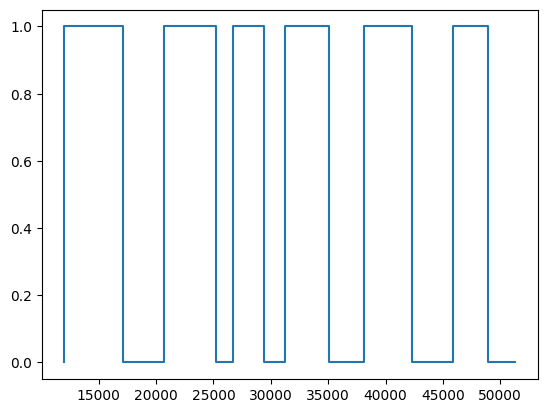

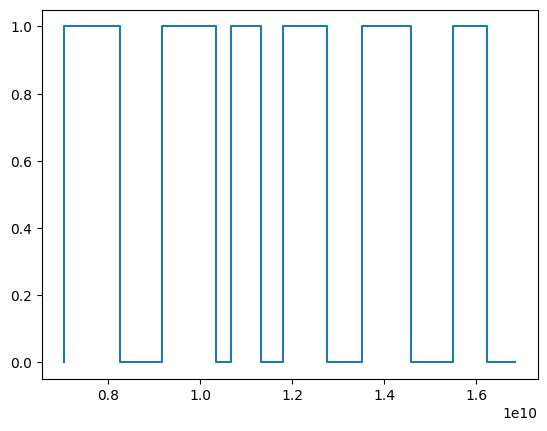

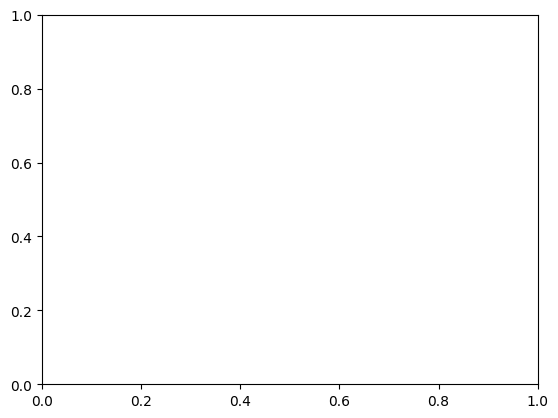

In [32]:
# photometry sync example
# binarise photometry input events
photometry_sync_events = photometry[0]["Events"]
photometry_sync_events = photometry_sync_events[~photometry_sync_events.isna()] # Restrict to events
photometry_sync_events = photometry_sync_events.transform(lambda x: int(x.split('*')[2])) # Extract channel value

# extract corresponding events in onix
digital_data["_sync_line"] = 1 - digital_data["DigitalInputs"] & 1

window = range(0, 13)
plt.figure()
plt.step(photometry_sync_events.index[window], photometry_sync_events.values[window])

plt.figure()
plt.step(digital_data.iloc[window]["Clock"], digital_data.iloc[window]["_sync_line"])

plt.figure()
plt.scatter(photometry_sync_events.index, digital_data["Clock"])

# define conversion functions between timestamps (onix to harp)
m, b = np.polyfit(photometry_sync_events.index, digital_data["Clock"], 1)
photometry_to_onix_time = lambda x: x*m + b
photometry_to_harp_time = lambda x: onix_to_harp_timestamp(photometry_to_onix_time(x))
onix_time_to_photometry = lambda x: (x - b) / m

                                                          Event        Seconds
Time                                                                          
1904-01-06 01:57:35.640256  LinearRegularMismatch block started  439055.640256


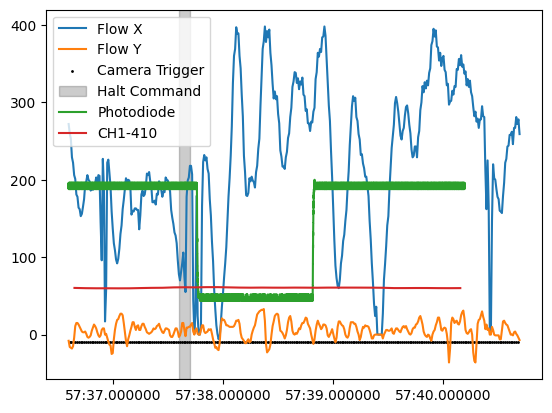

In [23]:
# example, see harp data, experiment events, onix data for a given window, synchronised.
# where did the LinearRegularMismatch block start (approximately)?
block_start = experiment_events[experiment_events["Event"].eq("LinearRegularMismatch block started")]
print(block_start)

# Get the first 20 halt times after this block started
block_halts = experiment_events[(experiment_events["Event"].eq("Apply halt: 1s")) & (experiment_events.index > block_start.index[0])].iloc[0:20]

# Plot flow sensor and camera triggers during given halt period
idx = 0
sec_start = block_halts.index[idx]
sec_stop = block_halts.index[idx+1]
min_time = sec_start - pd.DateOffset(seconds=1)
max_time = sec_stop + pd.DateOffset(seconds=0.5)

plt.figure()
plt.plot(flow_sensor['OpticalTrackingRead0X'][min_time:max_time], label='Flow X')
plt.plot(flow_sensor['OpticalTrackingRead0Y'][min_time:max_time], label='Flow Y')
plt.scatter(camera_triggers[min_time:max_time].index, np.ones((1, len(camera_triggers[min_time:max_time]))) * -10, s=1, c='k', label='Camera Trigger')
plt.axvspan(sec_start, sec_start + pd.DateOffset(seconds=0.1), color='black', alpha=0.2, label='Halt Command')

# overlay the onix photodiode signal in converted time
onix_sec_start_time = harp_to_onix_clock(block_halts.iloc[idx]["Seconds"] - 1)
onix_sec_start_index = np.where(analog_clock >= onix_sec_start_time)[0][0]

onix_sec_stop_time = harp_to_onix_clock(block_halts.iloc[idx+1]["Seconds"])
onix_sec_stop_index = np.where(analog_clock >= onix_sec_stop_time)[0][0]
plt.plot(onix_to_harp_timestamp(analog_clock[onix_sec_start_index:onix_sec_stop_index]), analog_data[onix_sec_start_index:onix_sec_stop_index, 0], label='Photodiode')

# overlay photometry
photometry_sec_start_time = onix_time_to_photometry(onix_sec_start_time)
photometry_sec_stop_time = onix_time_to_photometry(onix_sec_stop_time)
photometry_sec = photometry[0].loc[(photometry[0].index >= photometry_sec_start_time) & (photometry[0].index <= photometry_sec_stop_time)]

plt.plot(photometry_to_harp_time(photometry_sec.index), photometry_sec['CH1-410'], label='CH1-410')

plt.legend()